In [717]:
import agentpy as ap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [718]:
def normalize(v):
    """ Normalize a vector to length 1. """
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [719]:
class Carro(ap.Agent):

    def definirVelocidades(self):
        if self.ruta[0] == 'B' and self.ruta[1] == 'A':
            return [[0.5,0.0],[0.0,0.5],[-0.5,0.0]]
        elif self.ruta[0] == 'B' and self.ruta[1] == 'B':
            return [[0.5,0.0],[0.5,0.0],[0.5,0.0]]
        elif self.ruta[0] == 'C' and self.ruta[1] == 'B':
            return [[0.0,0.5],[0.0,0.5],[-0.5,0.0]]
        elif self.ruta[0] == 'C' and self.ruta[1] == 'C':
            return [[0.0,0.5],[0.0,0.5],[0.0,0.5]]
        elif self.ruta[0] == 'A' and self.ruta[1] == 'A':
            return [[-0.5,0.0],[-0.5,0.0],[-0.5,0.0]]
        else:
            print(self.ruta)

    def setup(self, calleAct, direccion, destino):
        self.ruta = [calleAct,destino]
        self.direccion = direccion
        self.velocidadesRuta = self.definirVelocidades()
        self.seccion = 0
        self.velocity = normalize(self.velocidadesRuta[self.seccion])

    def setup_pos(self, space):
        self.space = space
        self.pos = space.positions[self]

    def revisarSemaforo(self, semaforo):
        pos = self.pos

        luz = semaforo.mostrarLuz()

        if(self.seccion == 0):
            if(luz[1] == 1 and 
                (pos[0] in range(semaforo.rangoInter[0][0]-5,semaforo.rangoInter[0][0]) or pos[0] in range(semaforo.rangoInter[0][1],semaforo.rangoInter[0][0]+5)) or
                (pos[1] in range(semaforo.rangoInter[1][0]-5,semaforo.rangoInter[1][0]) or pos[1] in range(semaforo.rangoInter[1][1],semaforo.rangoInter[1][1]+5))):
                self.velocity = normalize([self.velocidadesRuta[self.seccion][0]/2,self.velocidadesRuta[self.seccion][1]/2])
            elif((luz[1] == 2 or not np.array_equal(luz[0],self.ruta)) and (pos[0] in range(semaforo.rangoInter[0][0]-1,semaforo.rangoInter[0][1]+1) and pos[1] in range(semaforo.rangoInter[1][0]-1,semaforo.rangoInter[1][1]+1))):
                self.velocity = normalize([0.0,0.0])
            elif(luz[1] == 0 and np.array_equal(luz[0],self.ruta) and (pos[0] in range(semaforo.rangoInter[0][0]+2,semaforo.rangoInter[0][1]-2) and pos[1] in range(semaforo.rangoInter[1][0]+2,semaforo.rangoInter[1][1]-2))):
                self.seccion = 1
            else:
                self.velocity = normalize(self.velocidadesRuta[self.seccion])
        else:
            self.velocity = normalize(self.velocidadesRuta[self.seccion])
        
        if(self.seccion == 1 and not (pos[0] in range(semaforo.rangoInter[0][0]+2,semaforo.rangoInter[0][1]-2) and pos[1] in range(semaforo.rangoInter[1][0]+2,semaforo.rangoInter[1][1]-2))):
            self.seccion = 2

    def revisarDestino(self, model):
        if 0 in self.pos or 40 in self.pos:
            model.space.remove_agents(self)
            model.agents.remove(self)

    def update_position(self):
        self.space.move_by(self, self.velocity)


In [720]:
class Semaforo(ap.Agent):

    def setup(self, rutas, tiempoRutas):
        self.color = 0
        self.rutaAct = 0
        self.rutas = rutas
        self.tiempoRutas = tiempoRutas
                
    
    def setupSpace(self, space):
        self.space = space
        self.pos = space.positions[self]
        self.rangoInter = [[20,30],[5,30]]

    def mostrarLuz(self):
        return [self.rutas[self.rutaAct], self.color]

    def siguienteLuz(self, tiempo):
        if(tiempo >= self.tiempoRutas[self.rutaAct][self.color]):
            if(self.color == 2):
                self.color = 0
                if(self.rutaAct == len(self.rutas)-1):
                    self.rutaAct = 0
                else:
                    self.rutaAct += 1
            else:
                self.color+=1
            return True
        return False


In [721]:
class CarModel(ap.Model):
    def setup(self):
        self.time = 0
        self.agentNum = 0
        self.space = ap.Space(self, shape=[self.p.size]*self.p.ndim)

        rutasDisp = [['B','A'],['B','B'],['C','B'],['C','C'],['A','A']]
        posiciones = [(1,20),(1,23),(23,1),(27,1),(35,30)]

        origenes = []
        destinos = []
        self.posicionesIniciales = []

        for i in range(1,20):
            rutaIdx = self.random.randint(0,4)
            ruta = rutasDisp[rutaIdx]
            origenes.append(ruta[0])
            destinos.append(ruta[1])
            self.posicionesIniciales.append(posiciones[rutaIdx])

        
        origenesPar = ap.AttrIter(origenes)
        destinosPar = ap.AttrIter(destinos)
        
        
        self.agents = ap.AgentDList(self,19,Carro,calleAct=origenesPar,direccion=1,destino=destinosPar)
        print("a")
        self.agentsSem = ap.AgentDList(self,1,Semaforo,rutas=rutasDisp,tiempoRutas=[[10,10,10],[10,10,10],[10,10,10],[10,10,10],[10,10,10]])
        print("b")        
        self.space.add_agents(self.agents[0], self.posicionesIniciales[0])
        print("c")
        self.space.add_agents(self.agentsSem, [(30,10)])
        print("d")
        self.agents.setup_pos(self.space)
        self.agentsSem.setupSpace(self.space)

        

    def update(self):
        if self.agentNum < 20:
            self.agentNum += 1
            self.space.add_agents(self.agents[self.agentNum], self.posicionesIniciales[self.agentNum])

        self.time += 1
        change = self.agentsSem[0].siguienteLuz(self.time)
        if(change):
            self.time = 0
        self.agents.revisarSemaforo(self.agentsSem[0])


    def step(self):
        self.agents.update_position()
        self.agents.revisarDestino(self)


    def mostrarSemaforo(self):
        return self.agentsSem[0].mostrarLuz()
        

In [722]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Semáforo: {m.mostrarSemaforo()}\n")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
    ax.set_axis_off()

def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

In [723]:
parameters2D = {
    'size': 40,
    'steps': 300,
    'ndim': 2
}

a
b


TypeError: getattr(): attribute name must be string

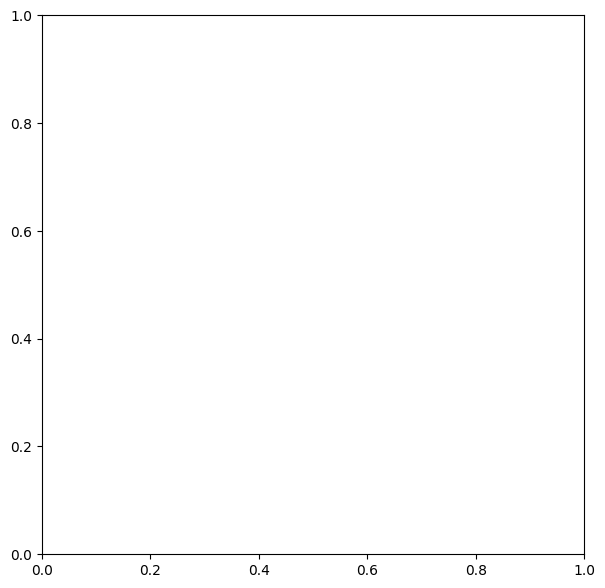

In [724]:
animation_plot(CarModel, parameters2D)